# Homework 6: Classification

## The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, puctuation, etc. of written sentences.
- 10 pt: Codes are written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

This homework assignment is very similar to the in-class lab exercise that you completed this week.


The dataset is from the "Malicious and Benign Websites" Kaggle project at https://www.kaggle.com/xwolf12/malicious-and-benign-websites/home (you'll need to go to that URL to get a full description of the data).

From the overview:

> The project consisted to evaluate different classification models to predict malicious and benign websites, based on application layer and network characteristics. The data were obtained by using different verified sources of benign and malicious URL's, in a low interactive client honeypot to isolate network traffic. We used additional tools to get other information, such as, server country with Whois.

Your task is to build the best classifier you can, choosing from either Random Forests or Naive Bayes classifiers (i.e. no XGBoost, SVM, Logistic Regression, etc.).

We have provided training and testing datasets for you to use, that way you're not going to introduce the problem of random sampling when you test your models.

1. Build both Random Forest (10 points) and Naive Bayes (10 points) classifiers to predict the TYPE variable.

2. Experiment with changing the number of "folds" in your cross-validator for your Random Forest classifiers (10 points).

3. Tune your Random Forest model by varying hyperparamters (15 points).

3. Experiment with setting the appropriate values for *priors* in the Naive Bayes model (the priors should correspond to the proportions of the TYPE values) (10 points).

4. Report the most important feature(s) based on your Random Forest classifier (10 points).

5. Summarize your findings, including which classifier and paramters gave you the best results and include an in-depth explanation of how you might improve your results.  You should also investigate what the different fields mean, so you'll need to do some research about websites and internet protocols! (15 points)


In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split #for splitting data 
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
import sklearn.externals.six as sksix
import IPython.display as ipd
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import os

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing


## Creating training dataset, replacing NaN values

In [2]:
le = preprocessing.LabelEncoder()

In [3]:
df_malicious_full = pd.read_csv('malicious_and_benign.csv')
df_malicious_test = pd.read_csv('malicious_and_benign_test.csv')

df_malicious_test.columns
# df_malicious_train.head(20)

Index(['URL', 'URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CHARSET', 'SERVER',
       'CONTENT_LENGTH', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO', 'WHOIS_REGDATE',
       'WHOIS_UPDATED_DATE', 'TCP_CONVERSATION_EXCHANGE',
       'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS', 'APP_BYTES', 'SOURCE_APP_PACKETS',
       'REMOTE_APP_PACKETS', 'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES',
       'APP_PACKETS', 'DNS_QUERY_TIMES', 'Type'],
      dtype='object')

In [4]:
df_malicious_train= pd.concat([df_malicious_full, df_malicious_test]).drop_duplicates(keep=False)

In [5]:
df_columns = df_malicious_train.columns
for column in df_columns:
    if df_malicious_train[column].dtype == object:
        df_malicious_train[column] = le.fit_transform(df_malicious_train[column].astype(str)).astype(float)
# df_malicious_train

In [6]:
from sklearn.preprocessing import Imputer
for each in df_malicious_train:
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    imp.fit(df_malicious_train[[each]])
    df_malicious_train[each]=imp.transform(df_malicious_train[[each]])
df_malicious_train.head(10)

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,1263.0,16.0,7.0,4.0,175.0,263.000000,27.0,85.0,47.0,526.0,...,0.0,2.0,700.0,9.0,10.0,1153.0,832.0,9.0,2.0,1.0
1,633.0,16.0,6.0,3.0,54.0,15087.000000,27.0,85.0,759.0,526.0,...,7.0,4.0,1230.0,17.0,19.0,1265.0,1230.0,17.0,0.0,0.0
2,1191.0,16.0,6.0,5.0,99.0,324.000000,27.0,85.0,759.0,526.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,103.0,17.0,6.0,1.0,175.0,162.000000,39.0,4.0,689.0,54.0,...,22.0,3.0,3812.0,39.0,37.0,18784.0,4380.0,39.0,8.0,0.0
4,780.0,17.0,6.0,3.0,108.0,124140.000000,39.0,122.0,73.0,32.0,...,2.0,5.0,4278.0,61.0,62.0,129889.0,4586.0,61.0,4.0,0.0
5,441.0,18.0,7.0,3.0,175.0,12343.020539,32.0,61.0,548.0,389.0,...,6.0,9.0,894.0,11.0,13.0,838.0,894.0,11.0,0.0,0.0
8,1366.0,20.0,5.0,6.0,185.0,12343.020539,27.0,85.0,721.0,526.0,...,0.0,0.0,0.0,2.0,3.0,213.0,146.0,2.0,2.0,1.0
12,548.0,20.0,7.0,6.0,108.0,13716.000000,14.0,85.0,59.0,474.0,...,6.0,8.0,1492.0,20.0,20.0,2334.0,1784.0,20.0,4.0,0.0
13,851.0,20.0,6.0,1.0,175.0,3692.000000,27.0,85.0,127.0,175.0,...,19.0,4.0,3946.0,35.0,29.0,16408.0,4746.0,35.0,10.0,0.0
14,1154.0,20.0,7.0,1.0,26.0,13054.000000,27.0,85.0,759.0,526.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_test_columns = df_malicious_test.columns
for columns in df_test_columns:
    if df_malicious_test[columns].dtype == object:
        df_malicious_test[columns] = le.fit_transform(df_malicious_test[columns].astype(str)).astype(float)
df_malicious_test.head(5)

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,134.0,78,15,0.0,49.0,9.0,25.0,13.0,79.0,36.0,...,6,6,672,8,9,562,672,8,0.0,0
1,279.0,39,8,5.0,51.0,NaN,25.0,8.0,50.0,31.0,...,0,0,0,0,0,0,0,0,0.0,0
2,169.0,43,9,5.0,49.0,389.0,25.0,8.0,61.0,138.0,...,2,3,6008,87,107,147266,6312,87,4.0,0
3,280.0,52,10,0.0,5.0,5443.0,4.0,59.0,46.0,6.0,...,0,0,0,0,0,0,0,0,0.0,0
4,349.0,100,20,2.0,5.0,NaN,9.0,4.0,67.0,83.0,...,0,1,66,1,3,190,66,1,0.0,1


In [8]:
for each in df_malicious_test:
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    imp.fit(df_malicious_test[[each]])
    df_malicious_test[each]=imp.transform(df_malicious_test[[each]])
df_malicious_test.head(5)

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,134.0,78.0,15.0,0.0,49.0,9.000000,25.0,13.0,79.0,36.0,...,6.0,6.0,672.0,8.0,9.0,562.0,672.0,8.0,0.0,0.0
1,279.0,39.0,8.0,5.0,51.0,9200.947368,25.0,8.0,50.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,169.0,43.0,9.0,5.0,49.0,389.000000,25.0,8.0,61.0,138.0,...,2.0,3.0,6008.0,87.0,107.0,147266.0,6312.0,87.0,4.0,0.0
3,280.0,52.0,10.0,0.0,5.0,5443.000000,4.0,59.0,46.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,349.0,100.0,20.0,2.0,5.0,9200.947368,9.0,4.0,67.0,83.0,...,0.0,1.0,66.0,1.0,3.0,190.0,66.0,1.0,0.0,1.0


In [9]:
len(df_malicious_train),len(df_malicious_test)

(1424, 357)

# Trial model

In [10]:
malicious_rf_model = skens.RandomForestClassifier(n_estimators=20,oob_score=True, criterion='entropy')
malicious_rf_model.fit(df_malicious_train.ix[:,1:-1],df_malicious_train.Type)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [11]:
predicted_labels = malicious_rf_model.predict(df_malicious_test.ix[:,1:-1])


In [12]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(df_malicious_test.Type, predicted_labels)
print("Accuracy: {0:.2%}".format(accuracy))

Accuracy: 91.32%


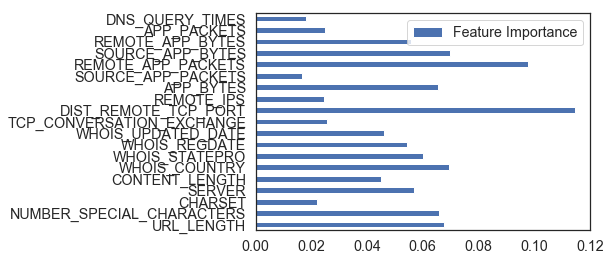

In [13]:
feat_importance = malicious_rf_model.feature_importances_
pd.DataFrame({'Feature Importance':feat_importance},
            index=df_malicious_train.columns[1:-1]).plot(kind='barh')

# Model 1

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
param_grid = {
                 'n_estimators': [10, 15, 20, 25, 30],
                 'max_depth': [3, 5, 7, 9],
             }

In [16]:
mal_grid1 = GridSearchCV(malicious_rf_model, param_grid, cv=10)
mal_grid1.fit(df_malicious_train.ix[:,:-1],df_malicious_train.Type)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 15, 20, 25, 30], 'max_depth': [3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [17]:
mal_grid1.best_params_

{'max_depth': 5, 'n_estimators': 20}

In [18]:
mal_grid1.best_score_

1.0

In [19]:
malicious_rf_model2 = skens.RandomForestClassifier(n_estimators=30,oob_score=True, criterion='entropy', max_depth=7)
malicious_rf_model2.fit(df_malicious_train.ix[:,1:-1],df_malicious_train.Type)

predicted_labels1 = malicious_rf_model2.predict(df_malicious_test.ix[:,1:-1])
# df_malicious_test['predicted_rf_tree'] = predicted_labels2

In [20]:
accuracy1 = accuracy_score(df_malicious_test.Type, predicted_labels1)
print("Accuracy: {0:.2%}".format(accuracy1))

Accuracy: 91.04%


# Model 2

In [21]:
mal_grid2 = GridSearchCV(malicious_rf_model, param_grid, cv=5)
mal_grid2.fit(df_malicious_train.ix[:,:-1],df_malicious_train.Type)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 15, 20, 25, 30], 'max_depth': [3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
mal_grid2.best_params_

{'max_depth': 7, 'n_estimators': 20}

In [23]:
mal_grid2.best_score_

1.0

In [24]:
malicious_rf_model3 = skens.RandomForestClassifier(n_estimators=20,oob_score=True, criterion='entropy', max_depth=5)
malicious_rf_model3.fit(df_malicious_train.ix[:,1:-1],df_malicious_train.Type)

predicted_labels2 = malicious_rf_model3.predict(df_malicious_test.ix[:,1:-1])
# df_malicious_test['predicted_rf_tree'] = predicted_labels2

In [25]:
accuracy2 = accuracy_score(df_malicious_test.Type, predicted_labels2)
print("Accuracy: {0:.2%}".format(accuracy2))

Accuracy: 89.92%


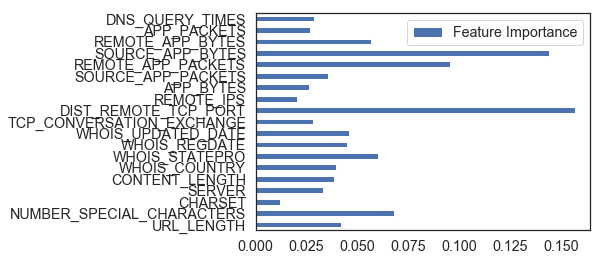

In [26]:
feat_importance2 = malicious_rf_model3.feature_importances_
pd.DataFrame({'Feature Importance':feat_importance2},
            index=df_malicious_train.columns[1:-1]).plot(kind='barh')

# Model 3

In [27]:
mal_grid3 = GridSearchCV(malicious_rf_model, param_grid, cv=40)
mal_grid3.fit(df_malicious_train.ix[:,:-1],df_malicious_train.Type)

GridSearchCV(cv=40, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 15, 20, 25, 30], 'max_depth': [3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [28]:
mal_grid3.best_params_

{'max_depth': 5, 'n_estimators': 25}

In [29]:
mal_grid3.best_score_

1.0

In [30]:
malicious_rf_model4 = skens.RandomForestClassifier(n_estimators=15,oob_score=True, criterion='entropy', max_depth=5)
malicious_rf_model4.fit(df_malicious_train.ix[:,1:-1],df_malicious_train.Type)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [31]:
predicted_labels3 = malicious_rf_model4.predict(df_malicious_test.ix[:,1:-1])
# df_malicious_test['predicted_rf_tree'] = predicted_labels

In [32]:
accuracy3 = accuracy_score(df_malicious_test.Type, predicted_labels3)
print("Accuracy: {0:.2%}".format(accuracy3))

Accuracy: 89.36%


# Naive Bayes


## No priors

In [35]:
# train the model
variables = list(df_malicious_train)
variables_train = variables[1:20]
mal_model = sknb.GaussianNB()
mal_model.fit(df_malicious_train[variables_train],df_malicious_train['Type'])

GaussianNB(priors=None)

In [36]:
type_pred = mal_model.predict(df_malicious_test[variables_train])
df_malicious_test['predicted_nb'] = type_pred


In [37]:
accuracy2 = accuracy_score(df_malicious_test.Type, type_pred)
print("Accuracy: {0:.2%}".format(accuracy2))

Accuracy: 33.05%


## Priors



In [38]:
type_1 = df_malicious_train[df_malicious_train["Type"] == 1]
type_0 = df_malicious_train[df_malicious_train["Type"] == 0]

In [39]:
len_type0= len(type_0)
len_type1 = len(type_1)

In [40]:
priors_0= len_type0/len(df_malicious_train["Type"])
priors_0                     

0.8834269662921348

In [41]:
priors_1 = len_type1/len(df_malicious_train["Type"])
priors_1
priors_list = [priors_0, priors_1]
priors_list

[0.8834269662921348, 0.11657303370786516]

In [42]:
mal_model2 = sknb.GaussianNB(priors= priors_list)
mal_model2.fit(df_malicious_train[variables_train],df_malicious_train['Type'])

GaussianNB(priors=[0.8834269662921348, 0.11657303370786516])

In [43]:
type_pred2 = mal_model2.predict(df_malicious_test[variables_train])

In [44]:
accuracy4 = accuracy_score(df_malicious_test.Type, type_pred2)
print("Accuracy: {0:.2%}".format(accuracy4))

Accuracy: 33.05%


## Incorporating different priors

In [45]:
model_priors1 = 0.99
model_priors2 = 0.01
priors_list2 = [model_priors1, model_priors2]

In [46]:
variables_train2 = variables[12:14]
mal_model3 = sknb.GaussianNB(priors= priors_list2)
mal_model3.fit(df_malicious_train[variables_train2],df_malicious_train['Type'])

GaussianNB(priors=[0.99, 0.01])

In [48]:
type_pred3 = mal_model3.predict(df_malicious_test[variables_train2])
accuracy5 = accuracy_score(df_malicious_test.Type, type_pred3)
print("Accuracy: {0:.2%}".format(accuracy5))

Accuracy: 85.99%


Random forest model
Given the entire dataset and a dataset for testing, I was able to create the training data set by combining both data sets and dropping duplicates (i.e data that was already in the test dat set). I used a label encoder to classify my data numerically, then I created a random forest model first and tuned with several cross validation values (10, 5, 40) to get the best parameter for each model with the different cv values. I got the highest accuracy (91.04%) with n_estimator 15 and max_depth 7 with a cv of 5. The most important feauture of the data using that model were Source_app_bytes and Dist_remote_tcp_ports.

Source_app bytes in this dataset represent the number of packets sent from honeypots to server. A Honeypot is an Internet-attached server that acts as a decoy, luring in potential hackers in order to study their activities and monitor how they are able to break into a system.

Dist_remote_tcp_ports in this dataset is the number of the ports detected and different to TCP.a port is an endpoint to a logical connection and the way a client program specifies a specific server program on a computer in a network. The port number identifies what type of port it is, for TCP(Transmission control Protocol) the port number is 1. TCP/IP is the suite of communications protocols used to connect hosts on the Internet. TCP/IP uses several protocols, the two main ones being TCP and IP. TCP is one of the main protocols in TCP/IP networks. Whereas the IP protocol deals only with packets, TCP enables two hosts to establish a connection and exchange streams of data. TCP guarantees delivery of data and also guarantees that packets will be delivered in the same order in which they were sent.


Naive Bayes model
To create my model, I used a subset of the data to train the data to predict type. I used that column on the train dataset and tried to predict using my model. I got a low accuracy of 33.05% without proirs. I added priors to my model used the proportion fo type 1 and type 2 as the priors  for my model, the accuracy stayed the same. I tried a number of combinations for the values of my priors. I use 0.99 and 010 as my prior values and it resulted in the highest accuracy. 

Tuning is a good method to use to improve results, I would test a larger number of combinations of the max_depth and n_estimators to identify the best combination, and also test all combinations of the variables in the training data set to identify which combination would be the best predictors to include in the model.We could go a step further and use ensemble methods. Ensemble methods combine the reuslts of multiple methods in order to get improved results. This method works well when you have multiple "good" models that can specialize in different parts of the problem. Ensemble methods involve:
bagging which was formally known as Bootstrapped Aggregation: This is where the same algorithm has different perspectives on the problem by being trained on different subsets of the training data.
Boosting: Which means that different algorithms are trained on the same training data.
Blending: Known more formally as Stacked Aggregation or Stacking is where a variety of models whose predictions are taken as input to a new model that learns how to combine the predictions into an overall prediction.

